## Imports

In [123]:
import sys
sys.path.append('/Users/pascal/path_tracer/mesh/lib')
from pmesh import *
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
import tqdm

In [124]:
#mesh_resolution = 10
mesh_resolution = 1

## Construct Meshes for the Top Wafer

In [125]:
radius = 0.5
points = []
numpts = 60
angles = np.linspace(0.,2.*3.14159265358979, num=numpts, endpoint=False)
for angle in angles:
    points.append([radius * np.cos(angle), radius * np.sin(angle)])
domain = Rectangle(Point(-1.5,-1.5), Point(1.5,1.5))
domain_drum = Polygon([Point(x,y) for (x,y) in points])
domain.set_subdomain(1, domain)
domain.set_subdomain(2, domain_drum)
mesh = generate_mesh(domain, mesh_resolution)
plot(mesh)

# Drum refinement

In [126]:
def double_refine(mesh, centers):
    epsilon = 0.000001
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2)< 0.3 and np.sqrt((x1-cx)**2+(y1-cy)**2) < 0.3 and np.sqrt((x2-cx)**2+(y2-cy)**2) < 0.3):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5 and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5 and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    cell_markers_drum = MeshFunction("size_t", mesh, 2)
    cell_markers_drum.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        marked = False
        for i in range(len(centers)):
            cx = centers[i][0]
            cy = centers[i][1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5+epsilon and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5+epsilon and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5+epsilon):
                cell_markers_drum[cell] = i+2
                marked = True
                break
        if not marked:
            cell_markers_drum[cell] = 1

    return mesh, cell_markers_drum

def triple_refine(mesh, centers):
    epsilon = 0.000001
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2)< 0.3 and np.sqrt((x1-cx)**2+(y1-cy)**2) < 0.3 and np.sqrt((x2-cx)**2+(y2-cy)**2) < 0.3):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5 and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5 and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.45 and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.45 and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.45):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    cell_markers_drum = MeshFunction("size_t", mesh, 2)
    cell_markers_drum.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        marked = False
        for i in range(len(centers)):
            cx = centers[i][0]
            cy = centers[i][1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5+epsilon and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5+epsilon and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5+epsilon):
                cell_markers_drum[cell] = i+2
                marked = True
                break
        if not marked:
            cell_markers_drum[cell] = 1

    return mesh, cell_markers_drum

def n_refine(mesh, centers, n):
    epsilon = 0.000001
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        for c in centers:
            cx = c[0]
            cy = c[1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2)< 0.3 and np.sqrt((x1-cx)**2+(y1-cy)**2) < 0.3 and np.sqrt((x2-cx)**2+(y2-cy)**2) < 0.3):
                cell_markers[cell] = True
    mesh = refine(mesh, cell_markers)
    for level in range(n-1):
        cell_markers = MeshFunction("bool", mesh, 2)
        cell_markers.set_all(False)
        for cell in cells(mesh):
            coords = cell.get_vertex_coordinates()
            x0,y0 = coords[0],coords[1]
            x1,y1 = coords[2],coords[3]
            x2,y2 = coords[4],coords[5]
            for c in centers:
                cx = c[0]
                cy = c[1]
                if(np.sqrt((x0-cx)**2+(y0-cy)**2)< 0.49 and np.sqrt((x1-cx)**2+(y1-cy)**2) < 0.49 and np.sqrt((x2-cx)**2+(y2-cy)**2) < 0.49):
                    cell_markers[cell] = True
        mesh = refine(mesh, cell_markers)
    cell_markers_drum = MeshFunction("size_t", mesh, 2)
    cell_markers_drum.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        marked = False
        for i in range(len(centers)):
            cx = centers[i][0]
            cy = centers[i][1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5+epsilon and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5+epsilon and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5+epsilon):
                cell_markers_drum[cell] = i+2
                marked = True
                break
        if not marked:
            cell_markers_drum[cell] = 1

    return mesh, cell_markers_drum

def radius_range_refine(mesh, centers, n, r_min, r_max):
    epsilon = 0.000001
    cell_markers = MeshFunction("bool", mesh, 2)
    cell_markers.set_all(False)
    for level in range(n):
        for cell in cells(mesh):
            coords = cell.get_vertex_coordinates()
            x0,y0 = coords[0],coords[1]
            x1,y1 = coords[2],coords[3]
            x2,y2 = coords[4],coords[5]
            for c in centers:
                cx = c[0]
                cy = c[1]
                if(np.sqrt((x0-cx)**2+(y0-cy)**2)< r_max and np.sqrt((x1-cx)**2+(y1-cy)**2) < r_max and np.sqrt((x2-cx)**2+(y2-cy)**2) < r_max):
                    if(np.sqrt((x0-cx)**2+(y0-cy)**2)> r_min and np.sqrt((x1-cx)**2+(y1-cy)**2) > r_min and np.sqrt((x2-cx)**2+(y2-cy)**2) > r_min):
                        cell_markers[cell] = True
        mesh = refine(mesh, cell_markers)
    cell_markers_drum = MeshFunction("size_t", mesh, 2)
    cell_markers_drum.set_all(False)
    for cell in cells(mesh):
        coords = cell.get_vertex_coordinates()
        x0,y0 = coords[0],coords[1]
        x1,y1 = coords[2],coords[3]
        x2,y2 = coords[4],coords[5]
        marked = False
        for i in range(len(centers)):
            cx = centers[i][0]
            cy = centers[i][1]
            if(np.sqrt((x0-cx)**2+(y0-cy)**2) <= 0.5+epsilon and np.sqrt((x1-cx)**2+(y1-cy)**2) <= 0.5+epsilon and np.sqrt((x2-cx)**2+(y2-cy)**2) <= 0.5+epsilon):
                cell_markers_drum[cell] = i+2
                marked = True
                break
        if not marked:
            cell_markers_drum[cell] = 1

    return mesh, cell_markers_drum

In [127]:
mesh, markers = n_refine(mesh, [[0.,0.]], 3)
mesh, markers = radius_range_refine(mesh, [[0.,0.]], 1, 0.5 - 0.5*0.85, 0.5 - 0.5*0.4)
mesh, markers = radius_range_refine(mesh, [[0.,0.]], 1, 0.5 - 0.5*0.8, 0.5 - 0.5*0.45)
mesh, markers = radius_range_refine(mesh, [[0.,0.]], 1, 0.4, 0.500001)

<IPython.core.display.Javascript object>


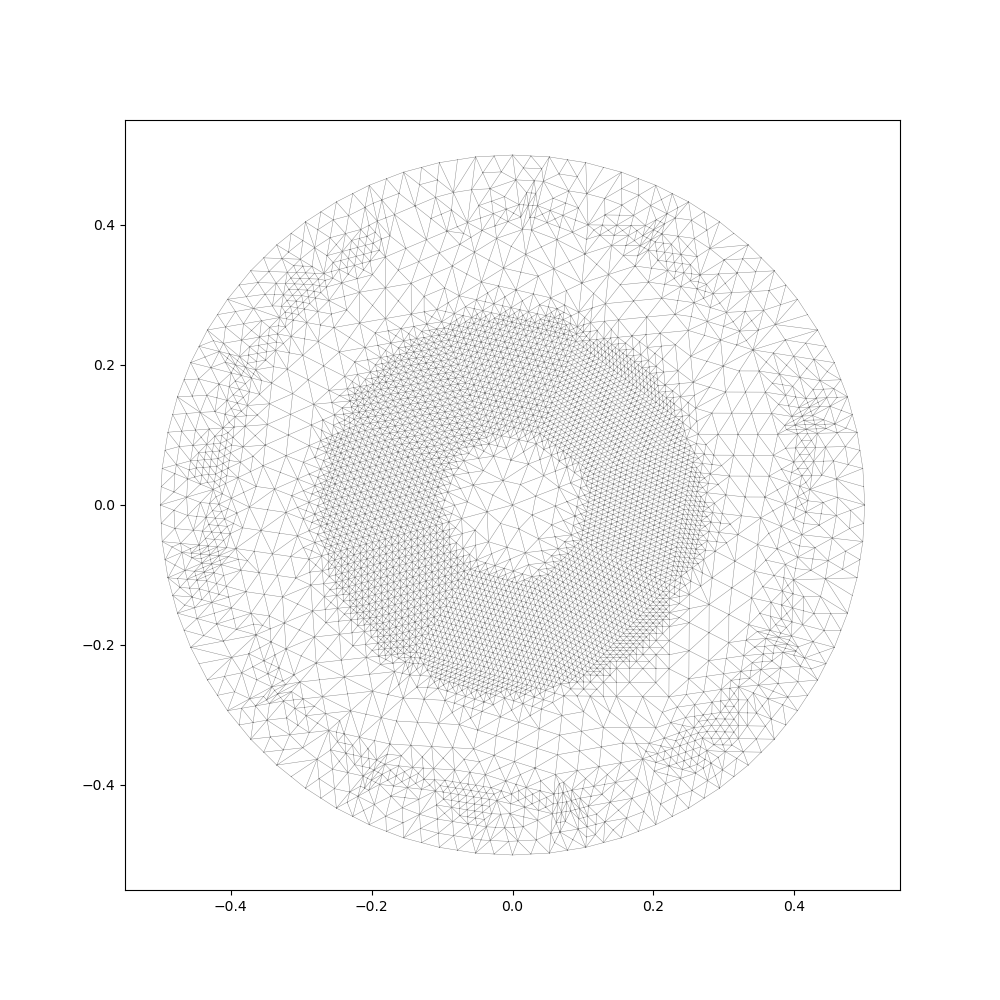

In [128]:
submesh_rect = SubMesh(mesh, markers, 1)
submesh_drum = SubMesh(mesh, markers, 2)
%matplotlib notebook
plt.figure(figsize=(10,10))
plot(submesh_drum, lw=0.3)
#plot(submesh_rect)

In [129]:
pmesh_drum = PMesh()
pmesh_rect = PMesh()
pmesh_tot = PMesh()
pmesh_drum.from_mshr_Mesh(submesh_drum)
pmesh_rect.from_mshr_Mesh(submesh_rect)
pmesh_tot.from_mshr_Mesh(mesh)

<IPython.core.display.Javascript object>


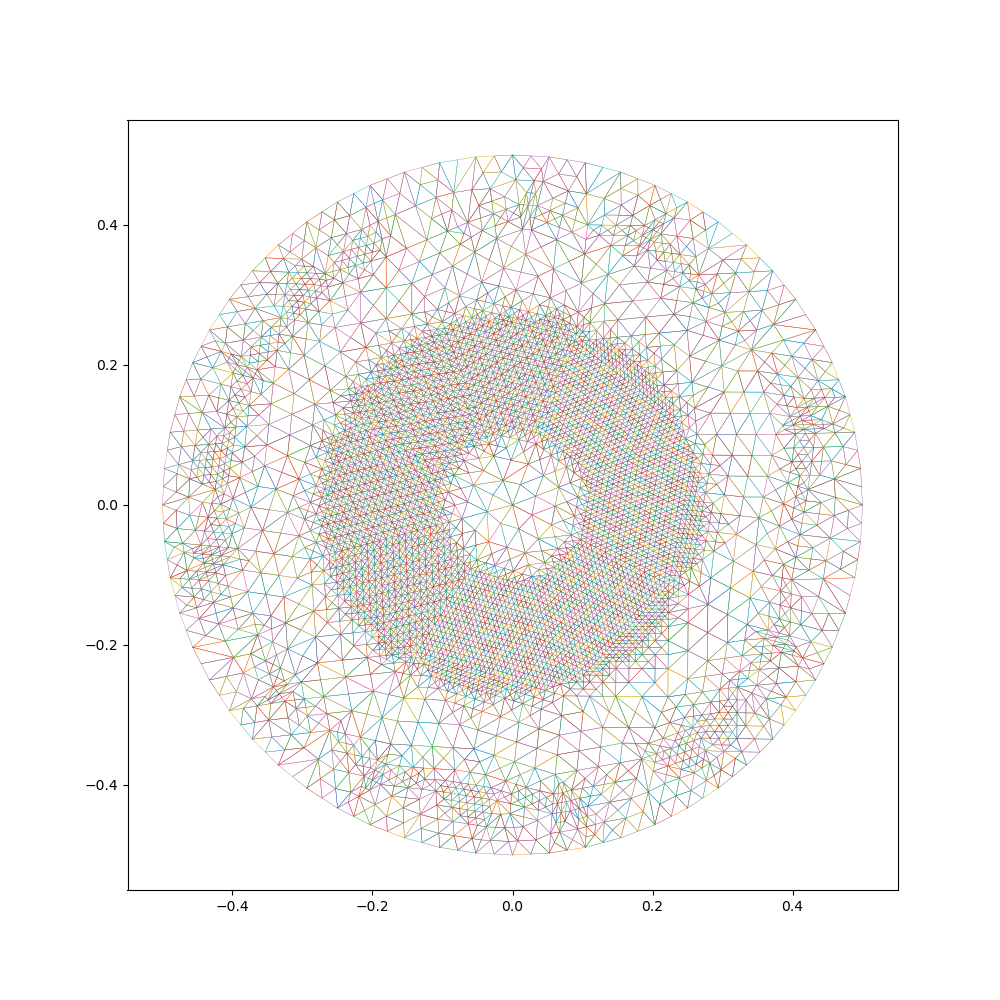

In [130]:
plt.figure(figsize=(10,10))
pmesh_drum.plot(linewidth=0.3)
#plt.savefig("drum_mesh.png", dpi=300, transparent=True)

<IPython.core.display.Javascript object>


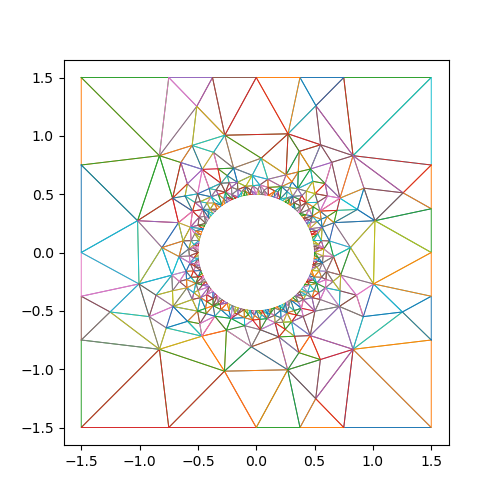

In [131]:
plt.figure(figsize=(5,5))
pmesh_rect.plot(linewidth=0.7)

In [132]:
pmesh_drum.print_cpp_mesh('../../meshes/mesh_top_drum_adaptive2.dat')
pmesh_rect.print_cpp_mesh('../../meshes/mesh_top_rect_adaptive2.dat')
pmesh_tot.print_cpp_mesh('../../meshes/mesh_top_tot_adaptive2.dat')

# Construct Meshes for the Bottom Wafer

In [ ]:
radius = 0.5
overlap = 0.240 #measured in design
outer_radius = 2.*radius - overlap
center_angles = [90.*np.pi/180., 210.*np.pi/180., 330.*np.pi/180.]
centers = [[outer_radius * np.cos(alpha), outer_radius * np.sin(alpha)] for alpha in center_angles]
points_d0 = []
points_d1 = []
points_d2 = []
numpts = 60
angles = np.linspace(0.,2.*np.pi, num=numpts, endpoint=False)
for angle in angles:
    points_d0.append([centers[0][0] + radius * np.cos(angle), centers[0][1] + radius * np.sin(angle)])
for angle in angles:
    points_d1.append([centers[1][0] + radius * np.cos(angle), centers[1][1] + radius * np.sin(angle)])
for angle in angles:
    points_d2.append([centers[2][0] + radius * np.cos(angle), centers[2][1] + radius * np.sin(angle)])
domain = Rectangle(Point(-1.5,-1.5), Point(1.5,1.5))
domain_drum0 = Polygon([Point(x,y) for (x,y) in points_d0])
domain_drum1 = Polygon([Point(x,y) for (x,y) in points_d1])
domain_drum2 = Polygon([Point(x,y) for (x,y) in points_d2])
domain.set_subdomain(1, domain)
domain.set_subdomain(2, domain_drum0)
domain.set_subdomain(3, domain_drum1)
domain.set_subdomain(4, domain_drum2)
mesh = generate_mesh(domain, mesh_resolution)
print(f"d0 center: {centers[0][0]}, {centers[0][1]}")
print(f"d1 center: {centers[1][0]}, {centers[1][1]}")
print(f"d2 center: {centers[2][0]}, {centers[2][1]}")
plot(mesh)

In [ ]:
mesh, markers = double_refine(mesh, centers)

In [ ]:
submesh_rect = SubMesh(mesh, markers, 1)
submesh_drum0 = SubMesh(mesh, markers, 2)
submesh_drum1 = SubMesh(mesh, markers, 3)
submesh_drum2 = SubMesh(mesh, markers, 4)

In [ ]:
pmesh_drum0 = PMesh()
pmesh_drum1 = PMesh()
pmesh_drum2 = PMesh()
pmesh_rect = PMesh()
pmesh_drum0.from_mshr_Mesh(submesh_drum0)
pmesh_drum1.from_mshr_Mesh(submesh_drum1)
pmesh_drum2.from_mshr_Mesh(submesh_drum2)
pmesh_rect.from_mshr_Mesh(submesh_rect)

In [ ]:
plt.figure(figsize=(10,10))
pmesh_rect.plot(linewidth=0.7)

In [ ]:
plt.figure(figsize=(5,5))
pmesh_drum0.plot(linewidth=0.7)

In [ ]:
plt.figure(figsize=(5,5))
pmesh_drum1.plot(linewidth=0.7)

In [ ]:
plt.figure(figsize=(5,5))
pmesh_drum2.plot(linewidth=0.7)

In [ ]:
pmesh_drum0.print_cpp_mesh('../../meshes/mesh_bottom_drum0.dat')
pmesh_drum1.print_cpp_mesh('../../meshes/mesh_bottom_drum1.dat')
pmesh_drum2.print_cpp_mesh('../../meshes/mesh_bottom_drum2.dat')
pmesh_rect.print_cpp_mesh('../../meshes/mesh_bottom_rect.dat')

# Get number of elements in total mesh

In [104]:
def ele_in_mesh(filename):
    file = open(filename)
    n_triang = int(file.readline().split('  ')[1])
    return n_triang

In [106]:
ele_in_mesh('../../meshes/mesh_top_drum_adaptive.dat')

9974

### Refined Mesh

In [113]:
path='../../meshes/'
filenames = ['mesh_top_drum.dat','mesh_top_rect.dat','mesh_bottom_drum0.dat','mesh_bottom_drum1.dat','mesh_bottom_drum2.dat','mesh_bottom_rect.dat']
multipliers = [2, 4, 2, 2, 2, 4]
mesh_elements_refined = 0
for i in range(len(filenames)):
    mesh_elements_refined += multipliers[i] * ele_in_mesh(path+filenames[i])
print(f"Mesh contains {mesh_elements_refined} elements.")

Mesh contains 13194 elements.


### Ultrafine Mesh

In [114]:
path='../../meshes/'
filenames = ['mesh_top_drum_ultrafine.dat','mesh_top_rect_ultrafine.dat','mesh_bottom_drum0.dat','mesh_bottom_drum1.dat','mesh_bottom_drum2.dat','mesh_bottom_rect.dat']
multipliers = [2, 4, 2, 2, 2, 4]
mesh_elements_ultrafine = 0
for i in range(len(filenames)):
    mesh_elements_ultrafine += multipliers[i] * ele_in_mesh(path+filenames[i])
print(f"Mesh contains {mesh_elements_ultrafine} elements.")

Mesh contains 15798 elements.


### Adaptive Mesh

In [136]:
path='../../meshes/'
filenames = ['mesh_top_drum_adaptive.dat','mesh_top_rect_adaptive.dat','mesh_bottom_drum0.dat','mesh_bottom_drum1.dat','mesh_bottom_drum2.dat','mesh_bottom_rect.dat']
multipliers = [2, 4, 2, 2, 2, 4]
mesh_elements_adaptive = 0
for i in range(len(filenames)):
    mesh_elements_adaptive += multipliers[i] * ele_in_mesh(path+filenames[i])
print(f"Mesh contains {mesh_elements_adaptive} elements.")

Mesh contains 31750 elements.


### Adaptive2 Mesh

In [137]:
path='../../meshes/'
filenames = ['mesh_top_drum_adaptive2.dat','mesh_top_rect_adaptive2.dat','mesh_bottom_drum0.dat','mesh_bottom_drum1.dat','mesh_bottom_drum2.dat','mesh_bottom_rect.dat']
multipliers = [2, 4, 2, 2, 2, 4]
mesh_elements_adaptive2 = 0
for i in range(len(filenames)):
    mesh_elements_adaptive2 += multipliers[i] * ele_in_mesh(path+filenames[i])
print(f"Mesh contains {mesh_elements_adaptive2} elements.")

Mesh contains 35030 elements.


### Runtime analysis and prediction

In [138]:
runtime_refined = 37.*60.+55.
runtime_ultrafine = 48.*60.+22.
runtime_adaptive = 104.*60.+5
print(f"Runtime increase: {runtime_ultrafine / runtime_refined}")
print(f"Meshsize increase: {mesh_elements_ultrafine / mesh_elements_refined}")
print(f"Runtime increases {(runtime_ultrafine / runtime_refined)/(mesh_elements_ultrafine / mesh_elements_refined)} / {(runtime_adaptive / runtime_refined)/(mesh_elements_adaptive / mesh_elements_refined)} as much as mesh size")
propconst = (runtime_ultrafine / runtime_refined)/(mesh_elements_ultrafine / mesh_elements_refined)
print(f"Projected runtime for adaptive2 mesh: {(propconst * mesh_elements_adaptive2 / mesh_elements_ultrafine * runtime_ultrafine)/60./60.} hours.")

Runtime increase: 1.2756043956043956
Meshsize increase: 1.197362437471578
Runtime increases 1.065345258615293 / 1.140732439214329 as much as mesh size
Projected runtime for adaptive2 mesh: 1.904247142320588 hours.
